In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


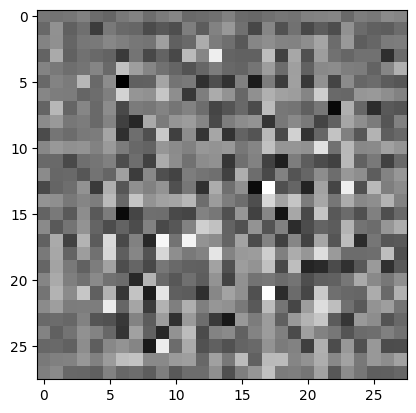

In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.00413445]], shape=(1, 1), dtype=float32)


In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
# Function to calculate MSE, SSIM, and PSNR
def calculate_metrics(original, generated):
    # MSE (Mean Squared Error)
    mse_value = tf.reduce_mean(tf.square(original - generated))

    # SSIM (Structural Similarity Index)
    ssim_value = tf.image.ssim(original, generated, max_val=1.0)

    # PSNR (Peak Signal to Noise Ratio)
    psnr_value = tf.image.psnr(original, generated, max_val=1.0)

    return mse_value, ssim_value, psnr_value


In [13]:
def generator_loss(fake_output, real_images, generated_images):
    adv_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    # Calculate perceptual losses for each image in the batch
    mse_loss, ssim_loss, psnr_loss = 0, 0, 0
    for i in range(real_images.shape[0]):
        mse, ssim_val, psnr_val = calculate_metrics(real_images[i], generated_images[i])
        mse_loss += mse
        ssim_loss += (1 - ssim_val)  # Use (1 - SSIM) to treat SSIM as a minimization metric
        psnr_loss += (20 - psnr_val)  # Use (20 - PSNR) to treat high PSNR as a minimization target

    # Normalize the perceptual losses
    mse_loss /= real_images.shape[0]
    ssim_loss /= real_images.shape[0]
    psnr_loss /= real_images.shape[0]

    # Combine the adversarial loss with perceptual losses
    total_gen_loss = adv_loss + 0.5 * mse_loss + 0.5 * ssim_loss + 0.1 * psnr_loss
    return total_gen_loss, mse_loss, ssim_loss, psnr_loss

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# Update the training step to include the perceptual metrics in generator loss
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss, mse_loss, ssim_loss, psnr_loss = generator_loss(fake_output, images, generated_images)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, mse_loss, ssim_loss, psnr_loss


In [18]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        gen_loss_total, disc_loss_total = 0, 0
        mse_loss_total, ssim_loss_total, psnr_loss_total = 0, 0, 0

        for image_batch in dataset:
            gen_loss, disc_loss, mse_loss, ssim_loss, psnr_loss = train_step(image_batch)
            gen_loss_total += gen_loss
            disc_loss_total += disc_loss
            mse_loss_total += mse_loss
            ssim_loss_total += ssim_loss
            psnr_loss_total += psnr_loss

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Print metrics for the epoch
        print(f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec')
        print(f'Generator Loss: {gen_loss_total / len(dataset):.4f}, '
              f'Discriminator Loss: {disc_loss_total / len(dataset):.4f}')
        print(f'MSE Loss: {mse_loss_total / len(dataset):.4f}, '
              f'SSIM Loss: {ssim_loss_total / len(dataset):.4f}, '
              f'PSNR Loss: {psnr_loss_total / len(dataset):.4f}')

    # Generate images after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


In [19]:
# Define `generate_and_save_images` to save generated outputs after each epoch
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()


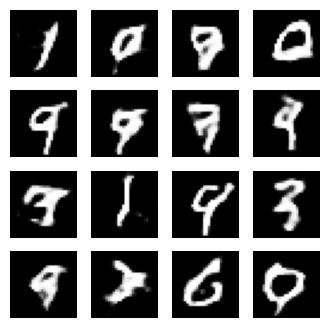

In [20]:
train(train_dataset, EPOCHS)

In [21]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [22]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [23]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-23-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-23-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 12.4 MB/s eta 0:00:00



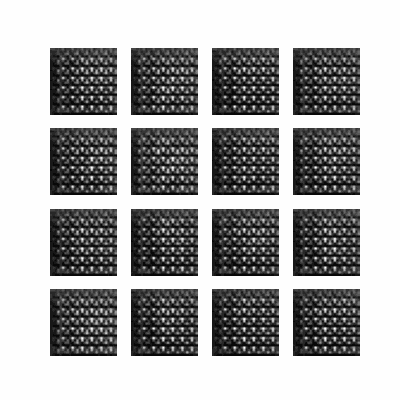

In [24]:
!pip install tensorflow-docs
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)